In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

This version, No CV, GridsearchCV, just train test split <br>
File: sub20210329_155120.csv

### Load Package

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
pd.options.mode.chained_assignment = None # hide warning Try using .loc[row_indexer,col_indexer] = value instead

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# https://medium.com/analytics-vidhya/recruit-restaurant-visitor-forecasting-f9ef87ba1073

In [3]:
%matplotlib inline

### Load Data

In [4]:
data_path = 'data/'

air_reserve = pd.read_csv(data_path + 'air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(data_path + 'air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(data_path + 'air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv(data_path + 'date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
weather = pd.read_csv('data_additional/' + 'weather_ready_to_use.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

### Feature Engineering Part 0

In [5]:
submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [6]:
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]

In [7]:
weather.head()

,store_id,visit_date,precipitation,low_temperature,avg_temperature,high_temperature,hours_sunlight,solar_radiation,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover
0,air_0f0cdeee6c9bf3d7,2016-01-01,0.0,4.8,7.9,12.3,8.6,NaN,2.8,6.2,1025.8,59.0,1029.6,1.8
1,air_0f0cdeee6c9bf3d7,2016-01-02,NaN,4.9,8.8,12.5,6.4,NaN,2.1,7.7,1021.9,68.0,1025.6,8.8
2,air_0f0cdeee6c9bf3d7,2016-01-03,NaN,7.9,11.0,14.3,7.3,NaN,2.2,9.7,1015.8,74.0,1019.6,5.3
3,air_0f0cdeee6c9bf3d7,2016-01-04,NaN,7.8,11.8,16.0,6.2,NaN,2.5,9.7,1014.8,71.0,1018.5,3.8
4,air_0f0cdeee6c9bf3d7,2016-01-05,0.0,8.5,10.3,12.0,1.5,NaN,2.5,7.4,1017.9,59.0,1021.6,6.5


In [8]:
air_reserve.head()

,store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [9]:
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek
air_reserve['month'] = pd.to_datetime(air_reserve['visit_date']).dt.month

In [10]:
hpg_reserve.head()

,store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [11]:
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek
hpg_reserve['month'] = pd.to_datetime(hpg_reserve['visit_date']).dt.month

In [12]:
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']

In [13]:
store_id_map['air_store_id'].head()

hpg_store_id
hpg_4bc649e72e2a239a    air_63b13c56b7201bd9
hpg_c34b496d0305a809    air_a24bf50c3e90d583
hpg_cd8ae0d9bbd58ff9    air_c7f78b4f3cba33ff
hpg_de24ea49dc25d6b8    air_947eb2cae4f3e8f2
hpg_653238a84804d8e7    air_965b2e0cf4119003
Name: air_store_id, dtype: object

In [14]:
hpg_store.head()

,store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [15]:
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)

In [16]:
data = pd.concat([air_visit, submission]).copy()
# data['visit_date'] = pd.to_datetime(data['visit_date'])
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
data['month'] = pd.to_datetime(data['visit_date']).dt.month

In [17]:
date_info.head()

,visit_date,holiday_flg
0,2016-01-01,1
1,2016-01-02,1
2,2016-01-03,1
3,2016-01-04,0
4,2016-01-05,0


In [18]:
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['friday_flg'] = (date_info['holiday_flg2']==5).astype(int)
date_info['weekend_flg'] = (date_info['holiday_flg2']>5).astype(int)
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

In [19]:
date_info.head(10)

,visit_date,holiday_flg,holiday_flg2,friday_flg,weekend_flg
0,2016-01-01,1,1,0,0
1,2016-01-02,1,1,1,0
2,2016-01-03,1,1,0,1
3,2016-01-04,0,0,0,0
4,2016-01-05,0,0,0,0
5,2016-01-06,0,0,0,0
6,2016-01-07,0,0,0,0
7,2016-01-08,0,0,0,0
8,2016-01-09,0,1,1,0
9,2016-01-10,0,1,0,1


In [20]:
air_store.head()

,store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [21]:
air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])

In [22]:
data.head()

,store_id,visit_date,visitors,id,dow,month
0,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,1
1,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,1
2,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,1
3,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,1
4,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,1


In [23]:
data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2', 'friday_flg', \
                             'weekend_flg']], on=['visit_date'],how='left')

In [24]:
data.head()

,store_id,visit_date,visitors,id,dow,month,air_genre_name,air_area_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2,friday_flg,weekend_flg
0,air_ba937bf13d40fb24,2016-01-13,3.258097,air_ba937bf13d40fb24_2016-01-13,2,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,0,0
1,air_ba937bf13d40fb24,2016-01-14,3.496508,air_ba937bf13d40fb24_2016-01-14,3,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,0,0
2,air_ba937bf13d40fb24,2016-01-15,3.401197,air_ba937bf13d40fb24_2016-01-15,4,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,0,0
3,air_ba937bf13d40fb24,2016-01-16,3.135494,air_ba937bf13d40fb24_2016-01-16,5,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1,1,0
4,air_ba937bf13d40fb24,2016-01-18,1.945910,air_ba937bf13d40fb24_2016-01-18,0,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,0,0


### Feature Engineering - Module

In [25]:
def concat(L):
    result = None
    for l in L:
        if result is None:
            result = l
        else:
            try:
                result[l.columns.tolist()] = l
            except:
                print(l.head())
    return result

def left_merge(data1,data2,on):
    data2_temp = data2.copy()
    columns = [f for f in data2.columns if f not in on]
    result = data1.merge(data2_temp,on=on,how='left')
    result = result[columns]
    return result


def diff_of_days(day1, day2):
    days = (parse(day1[:10]) - parse(day2[:10])).days
    return days

def date_add_days(start_date, days):
    end_date = parse(start_date[:10]) + timedelta(days=days)
    end_date = end_date.strftime('%Y-%m-%d')
    return end_date


def get_label(end_date,n_day):
    label_end_date = date_add_days(end_date, n_day)
    label = data[(data['visit_date'] < label_end_date) & (data['visit_date'] >= end_date)].copy()
    label['end_date'] = end_date
    label['diff_of_day'] = label['visit_date'].apply(lambda x: diff_of_days(x,end_date))
    label['month'] = label['visit_date'].str[5:7].astype(int)
    label['year'] = label['visit_date'].str[:4].astype(int)
    for i in [14, 7, 3, 2, 1, -1, -7, -14]:
        """
        The day before the holiday. The day after the holiday, and so on.
        """
        date_info_temp = date_info.copy()
        date_info_temp['visit_date'] = date_info_temp['visit_date'].apply(lambda x: date_add_days(x,i))
        date_info_temp.rename(columns={'holiday_flg':'ahead_holiday_{}'.format(i),\
                                       'holiday_flg2':'ahead_holiday2_{}'.format(i), \
                                       'friday_flg':'ahead_friday_{}'.format(i), \
                                       'weekend_flg':'ahead_weekend_{}'.format(i)},inplace=True)
        label = label.merge(date_info_temp, on=['visit_date'],how='left')
    label = label.reset_index(drop=True)
    return label


def truncate_dataset(key, n_day):
    # print ('key[0]', key[0])    
    start_date = date_add_days(key[0],-n_day)
    # print ('start_date', start_date)  
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)]
    return data_temp


def get_store_visitor_feat(label, key, n_day):
    """
    get_store_visitor_feat + get_store_week_feat
    """
    # print ('key', key)
    # print ('n_day', n_day)
    data_temp = truncate_dataset(key, n_day)

    result = data_temp.groupby(['store_id'], as_index=False)['visitors'].agg({'store_min{}'.format(n_day): 'min',
                                                                             'store_mean{}'.format(n_day): 'mean',
                                                                             'store_median{}'.format(n_day): 'median',
                                                                             'store_max{}'.format(n_day): 'max',
                                                                             'store_count{}'.format(n_day): 'count',
                                                                             'store_std{}'.format(n_day): 'std',
                                                                             'store_skew{}'.format(n_day): 'skew'})
    
    result2 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors'].agg({'store_dow_min{}'.format(n_day): 'min',
                                                                                     'store_dow_mean{}'.format(n_day): 'mean',
                                                                                     'store_dow_median{}'.format(n_day): 'median',
                                                                                     'store_dow_max{}'.format(n_day): 'max',
                                                                                     'store_dow_count{}'.format(n_day): 'count',
                                                                                     'store_dow_std{}'.format(n_day): 'std',
                                                                                     'store_dow_skew{}'.format(n_day): 'skew'})    
    
    result = left_merge(label, result, on=['store_id']).fillna(0)
    result2 = left_merge(label, result2, on=['store_id', 'dow']).fillna(0)
    final_result = pd.concat([result, result2], axis=1)
    return final_result


def get_store_exp_visitor_feat(label, key, n_day):
    data_temp = truncate_dataset(key, n_day)
    data_temp['diff_of_day'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    result_list = pd.DataFrame()
#     for weight in [0.85, 0.9, 0.95, 0.985]:
    for weight in [0.85, 0.9, 0.95, 0.985 ,0.97, 0.98, 0.99, 0.999, 0.9999]:
        # print (weight)
        data_temp['weight_{}'.format(weight)] = data_temp['diff_of_day'].apply(lambda x: weight**x)
        data_temp['visitors_{}'.format(weight)] = data_temp['visitors'] * data_temp['weight_{}'.format(weight)]
        result1 = data_temp.groupby(['store_id'], as_index=False)['visitors_{}'.format(weight)].agg({'store_exp{}_sum{}'.format(weight, n_day): 'sum'})
        result2 = data_temp.groupby(['store_id'], as_index=False)['weight_{}'.format(weight)].agg({'store_exp{}_weight_sum{}'.format(weight, n_day): 'sum'})
        result = result1.merge(result2, on=['store_id'], how='left')
        result['store_exp{}_sum{}'.format(weight, n_day)] = result['store_exp{}_sum{}'.format(weight, n_day)]/ \
            result['store_exp{}_weight_sum{}'.format(weight, n_day)]
        result = left_merge(label, result, on=['store_id']).fillna(0)   
        result_list = pd.concat([result_list, result], axis=1)

    return result_list




def get_store_week_diff_feat(label, key, n_day):
    data_temp = truncate_dataset(key, n_day)
    result = data_temp.set_index(['store_id','visit_date'])['visitors'].unstack()
    result = result.diff(axis=1).iloc[:,1:]
    c = result.columns
    result['store_diff_mean'] = np.abs(result[c]).mean(axis=1)
    result['store_diff_std'] = result[c].std(axis=1)
    result['store_diff_max'] = result[c].max(axis=1)
    result['store_diff_min'] = result[c].min(axis=1)
    result['store_diff_skew'] = result[c].skew(axis=1)
    result['store_diff_kurtosis'] = result[c].kurtosis(axis=1)
    result = left_merge(label, result[['store_diff_mean', 'store_diff_std', 'store_diff_max', 'store_diff_min', 'store_diff_skew', \
                                       'store_diff_kurtosis']],on=['store_id']).fillna(0)
    return result


def get_store_all_week_feat(label, key, n_day):
    data_temp = truncate_dataset(key, n_day)
    result_temp = data_temp.groupby(['store_id', 'dow'],as_index=False)['visitors'].agg({'store_dow_mean{}'.format(n_day): 'mean',
                                                                     'store_dow_median{}'.format(n_day): 'median',
                                                                     'store_dow_sum{}'.format(n_day): 'max',
                                                                     'store_dow_count{}'.format(n_day): 'count',
                                                                     'store_dow_min{}'.format(n_day): 'min',
                                                                     'store_dow_std{}'.format(n_day): 'std',
                                                                     'store_dow_skew{}'.format(n_day): 'skew'})
    result = pd.DataFrame()
    for i in range(7):
        result_sub = result_temp[result_temp['dow']==i].copy()
        result_sub = result_sub.set_index('store_id')
        result_sub = result_sub.add_prefix(str(i))
        result_sub = left_merge(label, result_sub, on=['store_id']).fillna(0)
        result = pd.concat([result,result_sub],axis=1)
    return result



def get_store_week_exp_feat(label, key, n_day):
    data_temp = truncate_dataset(key, n_day)
    data_temp['diff_of_day'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))

    result = None
    for weight in [0.9,0.95,0.97,0.98,0.985,0.99,0.999,0.9999]:
        data_temp['weight'] = data_temp['diff_of_day'].apply(lambda x: weight**x)
        data_temp['visitors1'] = data_temp['visitors'] * data_temp['weight']
        result1 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors1'].agg({'store_dow_exp_sum{}_{}'.format(n_day,weight): 'sum'})
        result2 = data_temp.groupby(['store_id', 'dow'], as_index=False)['weight'].agg({'store_dow_exp_weight_sum{}_{}'.format(n_day,weight): 'sum'})
        result_temp = result1.merge(result2, on=['store_id', 'dow'], how='left')
        result_temp['store_dow_exp_sum{}_{}'.format(n_day,weight)] = result_temp['store_dow_exp_sum{}_{}'.format(n_day,weight)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day,weight)]
        if result is None:
            result = result_temp
        else:
            result = result.merge(result_temp,on=['store_id','dow'],how='left')
    result = left_merge(label, result, on=['store_id', 'dow']).fillna(0)
    return result


def get_store_holiday_feat(label, key, n_day):
    data_temp = truncate_dataset(key, n_day)
    result1 = data_temp.groupby(['store_id', 'holiday_flg'], as_index=False)['visitors'].agg(
        {'store_holiday_min{}'.format(n_day): 'min',
         'store_holiday_mean{}'.format(n_day): 'mean',
         'store_holiday_median{}'.format(n_day): 'median',
         'store_holiday_max{}'.format(n_day): 'max',
         'store_holiday_count{}'.format(n_day): 'count',
         'store_holiday_std{}'.format(n_day): 'std',
         'store_holiday_skew{}'.format(n_day): 'skew'})
    result1 = left_merge(label, result1, on=['store_id', 'holiday_flg']).fillna(0)
    result2 = data_temp.groupby(['store_id', 'holiday_flg2'], as_index=False)['visitors'].agg(
        {'store_holiday2_min{}'.format(n_day): 'min',
         'store_holiday2_mean{}'.format(n_day): 'mean',
         'store_holiday2_median{}'.format(n_day): 'median',
         'store_holiday2_max{}'.format(n_day): 'max',
         'store_holiday2_count{}'.format(n_day): 'count',
         'store_holiday2_std{}'.format(n_day): 'std',
         'store_holiday2_skew{}'.format(n_day): 'skew'})
    result2 = left_merge(label, result2, on=['store_id', 'holiday_flg2']).fillna(0)
    result = pd.concat([result1, result2], axis=1)
    return result


def get_genre_visitor_feat(label, key, n_day):
    """
    get_genre_visitor_feat + get_genre_week_feat 
    """
    data_temp = truncate_dataset(key, n_day)
    result = data_temp.groupby(['air_genre_name'], as_index=False)['visitors'].agg({'genre_min{}'.format(n_day): 'min',
                                                                             'genre_mean{}'.format(n_day): 'mean',
                                                                             'genre_median{}'.format(n_day): 'median',
                                                                             'genre_max{}'.format(n_day): 'max',
                                                                             'genre_count{}'.format(n_day): 'count',
                                                                             'genre_std{}'.format(n_day): 'std',
                                                                             'genre_skew{}'.format(n_day): 'skew'})

    result2 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors'].agg({'genre_dow_min{}'.format(n_day): 'min',
                                                                                         'genre_dow_mean{}'.format(n_day): 'mean',
                                                                                         'genre_dow_median{}'.format(n_day): 'median',
                                                                                         'genre_dow_max{}'.format(n_day): 'max',
                                                                                         'genre_dow_count{}'.format(n_day): 'count',
                                                                                         'genre_dow_std{}'.format(n_day): 'std',
                                                                                         'genre_dow_skew{}'.format(n_day): 'skew'})

    result = left_merge(label, result, on=['air_genre_name']).fillna(0)
    result2 = left_merge(label, result2, on=['air_genre_name', 'dow']).fillna(0)
    final_result = pd.concat([result, result2], axis=1)

    return final_result


def get_genre_exp_visitor_feat(label, key, n_day):
    data_temp = truncate_dataset(key, n_day)
    data_temp['diff_of_day'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    result_list = pd.DataFrame()
#     for weight in [0.85, 0.9, 0.95, 0.985]:
    for weight in [0.85, 0.9, 0.95, 0.985 ,0.97, 0.98, 0.99, 0.999, 0.9999]:
        # print (weight)
        data_temp['weight_{}'.format(weight)] = data_temp['diff_of_day'].apply(lambda x: weight**x)
        data_temp['visitors_{}'.format(weight)] = data_temp['visitors'] * data_temp['weight_{}'.format(weight)]
        result1 = data_temp.groupby(['air_genre_name'], as_index=False)['visitors_{}'.format(weight)].agg({'genre_exp{}_sum{}'.format(weight, n_day): 'sum'})
        result2 = data_temp.groupby(['air_genre_name'], as_index=False)['weight_{}'.format(weight)].agg({'genre_exp{}_weight_sum{}'.format(weight, n_day): 'sum'})
        result = result1.merge(result2, on=['air_genre_name'], how='left')
        result['genre_exp{}_sum{}'.format(weight, n_day)] = result['genre_exp{}_sum{}'.format(weight, n_day)]/ \
            result['genre_exp{}_weight_sum{}'.format(weight, n_day)]
        result = left_merge(label, result, on=['air_genre_name']).fillna(0)   
        result_list = pd.concat([result_list, result], axis=1)    

    return result_list



def get_genre_week_exp_feat(label, key, n_day):
    data_temp = truncate_dataset(key, n_day)
    data_temp['diff_of_day'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    result_list = pd.DataFrame()
#     for weight in [0.85, 0.9, 0.95, 0.985]:
    for weight in [0.9,0.95,0.97,0.98,0.985,0.99,0.999,0.9999]:
        # print (weight)
        data_temp['weight_{}'.format(weight)] = data_temp['diff_of_day'].apply(lambda x: weight**x)
        data_temp['visitors_{}'.format(weight)] = data_temp['visitors'] * data_temp['weight_{}'.format(weight)]
        result1 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors_{}'.format(weight)].agg({'genre_dow_exp{}_sum{}'.format(weight, n_day): 'sum'})
        result2 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['weight_{}'.format(weight)].agg({'genre_dow_exp{}_weight_sum{}'.format(weight, n_day): 'sum'})
        result = result1.merge(result2, on=['air_genre_name', 'dow'], how='left')
        result['genre_dow_exp{}_sum{}'.format(weight, n_day)] = result['genre_dow_exp{}_sum{}'.format(weight, n_day)]/ \
            result['genre_dow_exp{}_weight_sum{}'.format(weight, n_day)]
        result = left_merge(label, result, on=['air_genre_name', 'dow']).fillna(0)   
        result_list = pd.concat([result_list, result], axis=1)    

    return result_list



def get_first_last_time(label, key, n_day):
    data_temp = truncate_dataset(key, n_day)
    data_temp = data_temp.sort_values('visit_date')

    result = data_temp.groupby('store_id')['visit_date'].agg([("first_time", lambda x: diff_of_days(key[0],np.min(x))),
                                                              ('last_time',lambda x: diff_of_days(key[0],np.max(x)))])
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result



def get_weather(label, key, n_day):
    start_date = date_add_days(key[0],-n_day)
    data_temp = weather[(weather.visit_date < key[0]) & (weather.visit_date > start_date)]
    result = data_temp.sort_values('visit_date')

    result = left_merge(label, result, on=['store_id','visit_date']).fillna(-1)
    return result


# air_reserve
def get_reserve_feat(label,key):
    label_end_date = date_add_days(key[0], key[1])
    air_reserve_temp = air_reserve[(air_reserve.visit_date >= key[0]) &             # key[0] 是'2017-04-23'
                                   (air_reserve.visit_date < label_end_date) &      # label_end_date 是'2017-05-31'
                                   (air_reserve.reserve_date < key[0])].copy()
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id',how='left')
    air_reserve_temp['diff_time'] = (pd.to_datetime(air_reserve['visit_datetime'])-pd.to_datetime(air_reserve['reserve_datetime'])).dt.days
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id')
    air_result = air_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg(
                   air_reserve_visitors_sum = "sum", air_reserve_visitors_count= 'count', air_reserve_visitors_skew= 'skew',
                   air_reserve_visitors_min= 'min', air_reserve_visitors_max= 'max', air_reserve_visitors_median= 'median',
                   air_reserve_visitors_mean= 'mean')
    air_store_diff_time_feat = air_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        air_store_diff_time_mean= 'mean', air_store_diff_time_median= 'median', air_store_diff_time_min= 'min',
        air_store_diff_time_max= 'max', air_store_diff_time_sum= 'sum', air_store_diff_time_skew= 'skew')
    air_diff_time_feat = air_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        air_diff_time_mean= 'mean', air_diff_time_min= 'min', air_diff_time_max= 'max',
        air_diff_time_median= 'median', air_diff_time_sum= 'sum', air_diff_time_skew= 'skew')
    air_result = air_result.unstack().fillna(0).stack()
    air_date_result = air_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg(
        air_date_sum= 'sum', air_date_count= 'count', air_date_min= 'min',
        air_date_max= 'max', air_date_skew= 'skew', air_date_median= 'median', air_date_mean= 'mean')
    # print ('part 1 finished')

    hpg_reserve_temp = hpg_reserve[(hpg_reserve.visit_date >= key[0]) & (hpg_reserve.visit_date < label_end_date) & (hpg_reserve.reserve_date < key[0])].copy()
    hpg_reserve_temp['diff_time'] = (pd.to_datetime(hpg_reserve['visit_datetime']) - pd.to_datetime(hpg_reserve['reserve_datetime'])).dt.days
    hpg_result = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg(hpg_reserve_sum= 'sum',
                                                                                              hpg_reserve_count= 'count',
                                                                                              hpg_reserve_mean= 'mean',
                                                                                              hpg_reserve_median= 'median',
                                                                                              hpg_reserve_min= 'min',
                                                                                              hpg_reserve_max= 'max',
                                                                                              hpg_reserve_skew= 'skew')
    hpg_result = hpg_result.unstack().fillna(0).stack()
    # print ('part 2 finished')

    hpg_date_result = hpg_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg(
        hpg_date_visitors= 'sum',
        hpg_date_count='count')
    hpg_store_diff_time_feat = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        hpg_store_diff_time_mean = 'mean', hpg_store_diff_time_median = 'median', hpg_store_diff_time_sum = 'sum',
        hpg_store_diff_time_min = 'min', hpg_store_diff_time_max = 'max', hpg_store_diff_time_skew = 'skew')
    hpg_diff_time_feat = hpg_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        hpg_diff_time_mean= 'mean', hpg_diff_time_median= 'median', hpg_diff_time_sum= 'sum',
        hpg_diff_time_min= 'min', hpg_diff_time_max= 'max', hpg_diff_time_skew= 'skew')
    # print ('part 3 finished')

    air_result = left_merge(label, air_result, on=['store_id','visit_date']).fillna(0)
    air_store_diff_time_feat = left_merge(label, air_store_diff_time_feat, on=['store_id', 'visit_date']).fillna(0)
    hpg_result = left_merge(label, hpg_result, on=['store_id', 'visit_date']).fillna(0)
    hpg_store_diff_time_feat = left_merge(label, hpg_store_diff_time_feat, on=['store_id', 'visit_date']).fillna(0)
    air_date_result = left_merge(label, air_date_result, on=['visit_date']).fillna(0)
    air_diff_time_feat = left_merge(label, air_diff_time_feat, on=['visit_date']).fillna(0)
    hpg_date_result = left_merge(label, hpg_date_result, on=['visit_date']).fillna(0)
    hpg_diff_time_feat = left_merge(label, hpg_diff_time_feat, on=['visit_date']).fillna(0)
    result = pd.concat([air_result,hpg_result,air_date_result,hpg_date_result,air_store_diff_time_feat,
                        hpg_store_diff_time_feat,air_diff_time_feat,hpg_diff_time_feat],axis=1)
    return result

# second feature
def second_feat(result):
    result['store_mean_7_14_rate'] = result['store_mean7']/(result['store_mean14']+0.01)
    result['store_mean_7_28_rate'] = result['store_mean7']/(result['store_mean28']+0.01)
    result['store_mean_7_600_rate'] = result['store_mean7']/(result['store_mean600']+0.01)
    result['store_mean_14_28_rate'] = result['store_mean14']/(result['store_mean28']+0.01)
    result['store_mean_28_56_rate'] = result['store_mean28'] / (result['store_mean56'] + 0.01)
    result['store_mean_56_600_rate'] = result['store_mean56'] / (result['store_mean600'] + 0.01)
    result['genre_mean_7_14_rate'] = result['genre_mean7'] / (result['genre_mean14'] + 0.01)    
    result['genre_mean_7_28_rate'] = result['genre_mean7'] / (result['genre_mean28'] + 0.01) 
    result['genre_mean_7_600_rate'] = result['genre_mean7'] / (result['genre_mean600'] + 0.01) 
    result['genre_mean_14_28_rate'] = result['genre_mean14'] / (result['genre_mean28'] + 0.01)
    result['genre_mean_28_56_rate'] = result['genre_mean28'] / (result['genre_mean56'] + 0.01)
    result['sgenre_mean_56_600_rate'] = result['genre_mean56'] / (result['genre_mean600'] + 0.01)
    return result

In [26]:
# add weather information
# https://github.com/anki1909/Recruit-Restaurant-Visitor-Forecasting/blob/master/Ready_to_use_Weather.ipynb

# is weekend
# https://github.com/MaxHalford/kaggle-recruit-restaurant/blob/master/Solution.ipynb

In [27]:
# 制作训练集
def make_feats(end_date,n_day):
    t0 = time.time()
    key = end_date,n_day
    print('data key为：{}'.format(key))
    print('add label')
    label = get_label(end_date,n_day)

    print('make feature...')
    result = [label]
    print('make 1...')
    prev_day_list = [7, 14, 28, 56, 600]
    for prev_day in prev_day_list:
        result.append(get_store_visitor_feat(label, key, prev_day))        # store features

    result.append(get_store_exp_visitor_feat(label, key, 600))    # store exp features

    # print('make 6...')
    result.append(get_store_week_diff_feat(label, key, 58))       # store dow diff features
    result.append(get_store_week_diff_feat(label, key, 600))      # store dow diff features
    result.append(get_store_all_week_feat(label, key, 600))       # store all week feat
    result.append(get_store_week_exp_feat(label, key, 600))       # store dow exp feat
    result.append(get_store_holiday_feat(label, key, 600))        # store holiday feat

    print('make 11...')
    for prev_day in prev_day_list:
        result.append(get_genre_visitor_feat(label, key, prev_day))        # store features

    result.append(get_genre_exp_visitor_feat(label, key, 600))     # genre feature
    result.append(get_genre_week_exp_feat(label, key, 600))        # genre dow exp feature

    # print('make 16...')
    result.append(get_reserve_feat(label,key))                      # air_reserve
    result.append(get_first_last_time(label,key,600))             # first time and last time
    result.append(get_weather(label,key,600))             # weather

    result.append(label)

    print('merge...')
    result = concat(result)

    result = second_feat(result)

    print('data shape：{}'.format(result.shape))
    print('spending {}s'.format(time.time() - t0))
    return result

In [28]:
# diff_of_days("2017-05-31", '2016-01-01')

In [32]:
# 制作训练集
def make_feats(end_date,n_day):
    t0 = time.time()
    key = end_date,n_day
    print('data key为：{}'.format(key))
    print('add label')
    label = get_label(end_date,n_day)

    print('make feature...')
    result = [label]
    print('make 1...')
    prev_day_list = [7, 14, 28, 56, 600]
    for prev_day in prev_day_list:
        result.append(get_store_visitor_feat(label, key, prev_day))        # store features

    result.append(get_store_exp_visitor_feat(label, key, 600))    # store exp features

    # print('make 6...')
    result.append(get_store_week_diff_feat(label, key, 58))       # store dow diff features
    result.append(get_store_week_diff_feat(label, key, 600))      # store dow diff features
    result.append(get_store_all_week_feat(label, key, 600))       # store all week feat
    result.append(get_store_week_exp_feat(label, key, 600))       # store dow exp feat
    result.append(get_store_holiday_feat(label, key, 600))        # store holiday feat

#     print('make 11...')
#     for prev_day in prev_day_list:
#         result.append(get_genre_visitor_feat(label, key, prev_day))        # store features

#     result.append(get_genre_exp_visitor_feat(label, key, 600))     # genre feature
#     result.append(get_genre_week_exp_feat(label, key, 600))        # genre dow exp feature

#     # print('make 16...')
#     result.append(get_reserve_feat(label,key))                      # air_reserve
    result.append(get_first_last_time(label,key,600))             # first time and last time
#     result.append(get_weather(label,key,600))             # weather

#     result.append(label)

    print('merge...')
    result = concat(result)

#     result = second_feat(result)

#     print('data shape：{}'.format(result.shape))
#     print('spending {}s'.format(time.time() - t0))
    return result

### Feature Engineering - Testing Version

In [33]:
# train_feat = pd.DataFrame()
# start_date = '2017-03-12'
# for i in range(1):
#     train_feat_sub = make_feats(date_add_days(start_date, i*(-7)),39)
#     train_feat = pd.concat([train_feat,train_feat_sub]) # (27728, 341)
# for i in range(1):
#     train_feat_sub = make_feats(date_add_days(start_date,i*(7)),42-(i*7))
#     train_feat = pd.concat([train_feat,train_feat_sub]) # (30035, 341), #(32019, 363)
# test_feat = make_feats(date_add_days(start_date, 42),39)

data key为：('2017-03-12', 39)
add label
make feature...
make 1...
merge...


In [34]:
# print (train_feat.shape)
# train_feat.head()

(27728, 232)


,store_id,visit_date,visitors,id,dow,month,air_genre_name,air_area_name,latitude,longitude,...,store_holiday_skew600,store_holiday2_min600,store_holiday2_mean600,store_holiday2_median600,store_holiday2_max600,store_holiday2_count600,store_holiday2_std600,store_holiday2_skew600,first_time,last_time
0,air_ba937bf13d40fb24,2017-03-12,2.484907,air_ba937bf13d40fb24_2017-03-12,6,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,-1.116209,0.693147,2.995240,3.258097,4.007333,75.0,0.824066,-1.267922,424,1
1,air_ba937bf13d40fb24,2017-03-13,2.079442,air_ba937bf13d40fb24_2017-03-13,0,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,-1.116209,1.098612,3.071017,3.135494,4.127134,277.0,0.502585,-0.635924,424,1
2,air_ba937bf13d40fb24,2017-03-14,2.079442,air_ba937bf13d40fb24_2017-03-14,1,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,-1.116209,1.098612,3.071017,3.135494,4.127134,277.0,0.502585,-0.635924,424,1
3,air_ba937bf13d40fb24,2017-03-15,3.091042,air_ba937bf13d40fb24_2017-03-15,2,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,-1.116209,1.098612,3.071017,3.135494,4.127134,277.0,0.502585,-0.635924,424,1
4,air_ba937bf13d40fb24,2017-03-16,2.564949,air_ba937bf13d40fb24_2017-03-16,3,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,-1.116209,1.098612,3.071017,3.135494,4.127134,277.0,0.502585,-0.635924,424,1


In [49]:
# train_feat.iloc[0, :].values

### Testing Part 1

In [ ]:
# # Testing

# train_feat = pd.DataFrame()
# start_date = '2017-03-12'

# end_date= date_add_days(start_date, 0*(-7))
# print ('end_date', end_date)
# n_day= 39
# label_end_date = date_add_days(end_date, n_day)
# print ('label_end_date', label_end_date)
# t0 = time.time()
# key = end_date,n_day
# print('data key为：{}'.format(key))
# print('add label')
# label = get_label(end_date,n_day)

# print('make feature...')
# result = [label]

end_date 2017-03-12
label_end_date 2017-04-20
data key为：('2017-03-12', 39)
add label
make feature...


In [ ]:
## Testing get_store_exp_visitor_feat

# start_date = date_add_days(key[0], -n_day)
# data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
# data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
# data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
# data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
# result1 = data_temp.groupby(['store_id'], as_index=False)['visitors'].agg({'store_exp_mean{}'.format(n_day): 'sum'})
# result2 = data_temp.groupby(['store_id'], as_index=False)['weight'].agg({'store_exp_weight_sum{}'.format(n_day): 'sum'})
# result = result1.merge(result2, on=['store_id'], how='left')
# result['store_exp_mean{}'.format(n_day)] = result['store_exp_mean{}'.format(n_day)]/result['store_exp_weight_sum{}'.format(n_day)]
# result = left_merge(label, result, on=['store_id']).fillna(0)

In [ ]:
data_temp.head()

,store_id,visit_date,visitors,id,dow,month,air_genre_name,air_area_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2,weight
317,air_ba937bf13d40fb24,38,1.686863,air_ba937bf13d40fb24_2017-02-02,3,2,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,0.563089
318,air_ba937bf13d40fb24,37,2.290846,air_ba937bf13d40fb24_2017-02-03,4,2,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,0.571664
319,air_ba937bf13d40fb24,36,1.992980,air_ba937bf13d40fb24_2017-02-04,5,2,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1,0.580369
320,air_ba937bf13d40fb24,35,0.816815,air_ba937bf13d40fb24_2017-02-05,6,2,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1,0.589207
321,air_ba937bf13d40fb24,34,1.486421,air_ba937bf13d40fb24_2017-02-06,0,2,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,0.598180


In [ ]:
data.head()

,store_id,visit_date,visitors,id,dow,month,air_genre_name,air_area_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2
0,air_ba937bf13d40fb24,2016-01-13,3.258097,air_ba937bf13d40fb24_2016-01-13,2,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
1,air_ba937bf13d40fb24,2016-01-14,3.496508,air_ba937bf13d40fb24_2016-01-14,3,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
2,air_ba937bf13d40fb24,2016-01-15,3.401197,air_ba937bf13d40fb24_2016-01-15,4,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0
3,air_ba937bf13d40fb24,2016-01-16,3.135494,air_ba937bf13d40fb24_2016-01-16,5,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1
4,air_ba937bf13d40fb24,2016-01-18,1.945910,air_ba937bf13d40fb24_2016-01-18,0,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0


In [ ]:
## Testing get_store_week_diff_feat

# data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
# result = data_temp.set_index(['store_id','visit_date'])['visitors'].unstack()
# result = result.diff(axis=1).iloc[:,1:]
# c = result.columns
# result.head()

visit_date,2017-02-03,2017-02-04,2017-02-05,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-11,2017-02-12,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-18,2017-02-19,2017-02-20,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-25,2017-02-26,2017-02-27,2017-02-28,2017-03-01,2017-03-02,2017-03-03,2017-03-04,2017-03-05,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-11
store_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
air_00a91d42b08b08d9,0.418710,-0.459532,NaN,NaN,-0.141079,-0.723919,0.661398,-0.138150,NaN,NaN,NaN,0.518794,0.232622,-0.386773,0.245122,-0.884202,NaN,NaN,0.838329,-0.084557,0.187212,-0.346276,-0.882389,NaN,NaN,-0.559616,-0.105361,0.635989,-0.125163,-0.456758,NaN,NaN,0.521297,-0.098440,0.296266,0.025318,-1.386294
air_0164b9927d20bcc3,-0.117783,-1.386294,NaN,NaN,1.041454,-0.635989,0.635989,-0.125163,-1.321756,NaN,NaN,NaN,NaN,NaN,NaN,1.098612,NaN,NaN,1.299283,-0.318454,0.559616,-0.154151,-1.791759,NaN,NaN,-0.223144,1.832581,-0.385662,-0.887303,-1.252763,NaN,NaN,0.182322,0.287682,NaN,NaN,0.356675
air_0241aa3964b7f861,NaN,-0.510826,0.000000,0.154151,-0.847298,1.203973,NaN,NaN,NaN,0.000000,NaN,NaN,0.510826,NaN,NaN,2.079442,-0.575364,-0.405465,0.405465,-0.405465,NaN,NaN,0.117783,0.105361,-0.356675,-0.336472,1.029619,NaN,NaN,-0.998529,-0.154151,0.00000,0.154151,0.826679,NaN,NaN,0.182322
air_0328696196e46f18,0.470004,-0.980829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.128232,NaN,NaN,NaN,NaN,NaN,-1.466337,0.693147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.287682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
air_034a3d5b40d5b1b1,-0.456758,1.133098,-0.710242,0.159065,-0.481838,0.322773,-0.802346,0.430783,0.300105,-0.160343,-0.737599,0.435318,0.302281,-0.938270,0.798508,0.182322,0.996333,-0.916291,-0.693147,0.961411,-0.693147,0.855666,0.262364,0.109199,-1.287854,0.223144,0.300105,0.036368,-0.287682,0.356675,0.125163,-0.81831,0.287682,0.139762,-0.191055,0.456758,0.064539


In [ ]:
print (label.shape)
label.head()

(27728, 24)


,store_id,visit_date,visitors,id,dow,month,air_genre_name,air_area_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2,end_date,diff_of_day,year,ahead_holiday_3,ahead_holiday2_3,ahead_holiday_2,ahead_holiday2_2,ahead_holiday_1,ahead_holiday2_1,ahead_holiday_-1,ahead_holiday2_-1
0,air_ba937bf13d40fb24,2017-03-12,2.484907,air_ba937bf13d40fb24_2017-03-12,6,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1,2017-03-12,0,2017,0,0,0,0,0,1,0,0
1,air_ba937bf13d40fb24,2017-03-13,2.079442,air_ba937bf13d40fb24_2017-03-13,0,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,2017-03-12,1,2017,0,0,0,1,0,1,0,0
2,air_ba937bf13d40fb24,2017-03-14,2.079442,air_ba937bf13d40fb24_2017-03-14,1,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,2017-03-12,2,2017,0,1,0,1,0,0,0,0
3,air_ba937bf13d40fb24,2017-03-15,3.091042,air_ba937bf13d40fb24_2017-03-15,2,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,2017-03-12,3,2017,0,1,0,0,0,0,0,0
4,air_ba937bf13d40fb24,2017-03-16,2.564949,air_ba937bf13d40fb24_2017-03-16,3,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,2017-03-12,4,2017,0,0,0,0,0,0,0,0


In [ ]:
# hpg_reserve_temp = hpg_reserve[(hpg_reserve.visit_date >= key[0]) & (hpg_reserve.visit_date < label_end_date) & (hpg_reserve.reserve_date < key[0])].copy()
# hpg_reserve_temp['diff_time'] = (pd.to_datetime(hpg_reserve['visit_datetime']) - pd.to_datetime(hpg_reserve['reserve_datetime'])).dt.days
# hpg_result = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg(hpg_reserve_visitors= 'sum',
#                                                                                               hpg_reserve_count= 'count')
# hpg_result = hpg_result.unstack().fillna(0).stack()

### Feature Engineering 

- [Solution for SpecificationError: nested renamer is not supported while agg() along with groupby()
](https://stackoverflow.com/questions/60229375/solution-for-specificationerror-nested-renamer-is-not-supported-while-agg-alo)

In [29]:
# import datetime
# import lightgbm as lgb

train_feat = pd.DataFrame()
start_date = '2017-03-12'
for i in range(58):
    train_feat_sub = make_feats(date_add_days(start_date, i*(-7)),39)
    train_feat = pd.concat([train_feat,train_feat_sub])
for i in range(1,6):
    train_feat_sub = make_feats(date_add_days(start_date,i*(7)),42-(i*7))
    train_feat = pd.concat([train_feat,train_feat_sub])
test_feat = make_feats(date_add_days(start_date, 42),39)

data key为：('2017-03-12', 39)
add label
make feature...
make 1...
make 11...
merge...
data shape：(27728, 407)
spending 136.9352309703827s
data key为：('2017-03-05', 39)
add label
make feature...
make 1...
make 11...
merge...
data shape：(27705, 407)
spending 127.11581897735596s
data key为：('2017-02-26', 39)
add label
make feature...
make 1...
make 11...
merge...
data shape：(27745, 407)
spending 124.87250208854675s
data key为：('2017-02-19', 39)
add label
make feature...
make 1...
make 11...
merge...
data shape：(27696, 407)
spending 122.76338791847229s
data key为：('2017-02-12', 39)
add label
make feature...
make 1...
make 11...
merge...
data shape：(27596, 407)
spending 121.84535598754883s
data key为：('2017-02-05', 39)
add label
make feature...
make 1...
make 11...
merge...
data shape：(27561, 407)
spending 136.57542300224304s
data key为：('2017-01-29', 39)
add label
make feature...
make 1...
make 11...
merge...
data shape：(27511, 407)
spending 129.35139107704163s
data key为：('2017-01-22', 39)
add la

data key为：('2017-04-02', 21)
add label
make feature...
make 1...
make 11...
merge...
data shape：(14999, 407)
spending 162.0262258052826s
data key为：('2017-04-09', 14)
add label
make feature...
make 1...
make 11...
merge...
data shape：(10008, 407)
spending 161.797269821167s
data key为：('2017-04-16', 7)
add label
make feature...
make 1...
make 11...
merge...
data shape：(5012, 407)
spending 152.43682599067688s
data key为：('2017-04-23', 39)
add label
make feature...
make 1...
make 11...
merge...
data shape：(32019, 407)
spending 177.66491770744324s


In [30]:
print (train_feat.shape)
train_feat.head()

(1322337, 407)


,store_id,visit_date,visitors,id,dow,month,air_genre_name,air_area_name,latitude,longitude,...,store_mean_7_600_rate,store_mean_14_28_rate,store_mean_28_56_rate,store_mean_56_600_rate,genre_mean_7_14_rate,genre_mean_7_28_rate,genre_mean_7_600_rate,genre_mean_14_28_rate,genre_mean_28_56_rate,sgenre_mean_56_600_rate
0,air_ba937bf13d40fb24,2017-03-12,2.484907,air_ba937bf13d40fb24_2017-03-12,6,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533
1,air_ba937bf13d40fb24,2017-03-13,2.079442,air_ba937bf13d40fb24_2017-03-13,0,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533
2,air_ba937bf13d40fb24,2017-03-14,2.079442,air_ba937bf13d40fb24_2017-03-14,1,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533
3,air_ba937bf13d40fb24,2017-03-15,3.091042,air_ba937bf13d40fb24_2017-03-15,2,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533
4,air_ba937bf13d40fb24,2017-03-16,2.564949,air_ba937bf13d40fb24_2017-03-16,3,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533


In [31]:
# train_feat.to_csv("train_feat.csv")
# test_feat.to_csv("test_feat.csv")

train_feat.to_hdf('train_feat.h5', key='train_feat', mode='w')
test_feat.to_hdf('test_feat.h5', key='test_feat', mode='w')

### Testing Part 2

In [ ]:
train_feat.query("store_id == 'air_ba937bf13d40fb24' & visit_date == '2017-03-12'")

,store_id,visit_date,visitors,id,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2,end_date,diff_of_day,month,year,ahead_holiday_3,ahead_holiday2_3,ahead_holiday_2,ahead_holiday2_2,ahead_holiday_1,ahead_holiday2_1,ahead_holiday_-1,ahead_holiday2_-1,store_min1000,store_mean1000,store_median1000,store_max1000,store_count1000,store_std1000,store_skew1000,store_min56,store_mean56,store_median56,store_max56,store_count56,store_std56,store_skew56,store_min28,store_mean28,...,genre_dow_median1000,genre_dow_max1000,genre_dow_count1000,genre_dow_std1000,genre_dow_skew1000,genre_dow_min56,genre_dow_mean56,genre_dow_median56,genre_dow_max56,genre_dow_count56,genre_dow_std56,genre_dow_skew56,genre_dow_min28,genre_dow_mean28,genre_dow_median28,genre_dow_max28,genre_dow_count28,genre_dow_std28,genre_dow_skew28,genre_dow_exp_mean1000,genre_dow_exp_weight_sum1000,air_reserve_visitors,air_reserve_count,hpg_reserve_visitors,hpg_reserve_count,air_date_visitors,air_date_count,hpg_date_visitors,hpg_date_count,air_store_diff_time_mean,hpg_store_diff_time_mean,air_diff_time_mean,hpg_diff_time_mean,first_time,last_time,store_mean_14_28_rate,store_mean_28_56_rate,store_mean_56_1000_rate,genre_mean_28_56_rate,sgenre_mean_56_1000_rate
0,air_ba937bf13d40fb24,2017-03-12,2.484907,air_ba937bf13d40fb24_2017-03-12,6,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1,2017-03-12,0,3,2017,0,0,0,0,0,1,0,0,0.693147,3.054871,3.156774,4.127134,352.0,0.585452,-1.125951,0.693147,2.767970,2.890372,4.007333,52.0,0.723012,-0.819637,1.386294,2.836491,...,2.70805,5.433722,3793.0,0.895657,-0.206033,0.693147,2.567922,2.564949,4.795791,594.0,0.911626,-0.099801,0.693147,2.609784,2.639057,4.795791,259.0,0.929881,-0.059916,2.596260,732.048889,0.0,0.0,0.0,0.0,1024.0,254.0,20361,4121,0.0,0.0,0.594488,6.539675,424.0,1.0,0.983217,1.021066,0.903128,1.002440,0.965330
6,air_ba937bf13d40fb24,2017-03-12,2.484907,air_ba937bf13d40fb24_2017-03-12,6,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1,2017-03-05,7,3,2017,0,0,0,0,0,1,0,0,0.693147,3.058702,3.178054,4.127134,346.0,0.584079,-1.144632,0.693147,2.771607,2.890372,4.007333,51.0,0.708553,-0.893715,1.386294,2.853608,...,2.70805,5.433722,3709.0,0.895521,-0.206422,0.693147,2.532624,2.564949,4.795791,594.0,0.911498,-0.091146,0.693147,2.591236,2.639057,4.795791,253.0,0.917247,-0.079987,2.588971,729.741513,0.0,0.0,0.0,0.0,449.0,80.0,8111,1186,0.0,0.0,2.337500,15.769815,417.0,1.0,0.993997,1.025884,0.903186,0.996392,0.960273
12,air_ba937bf13d40fb24,2017-03-12,2.484907,air_ba937bf13d40fb24_2017-03-12,6,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1,2017-02-26,14,3,2017,0,0,0,0,0,1,0,0,0.693147,3.063912,3.178054,4.127134,340.0,0.583355,-1.179524,0.693147,2.774592,2.890372,4.007333,48.0,0.706935,-1.009023,1.386294,2.813658,...,2.70805,5.433722,3623.0,0.895393,-0.209611,0.693147,2.520495,2.564949,4.795791,589.0,0.904571,-0.092468,0.693147,2.572693,2.564949,4.795791,248.0,0.903918,-0.136807,2.583634,725.176647,0.0,0.0,0.0,0.0,187.0,25.0,3927,469,0.0,0.0,2.360000,24.684435,410.0,1.0,1.016893,1.010438,0.902626,0.994895,0.960426
19,air_ba937bf13d40fb24,2017-03-12,2.484907,air_ba937bf13d40fb24_2017-03-12,6,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1,2017-02-19,21,3,2017,0,0,0,0,0,1,0,0,0.693147,3.071374,3.178054,4.127134,333.0,0.577090,-1.194712,0.693147,2.825040,2.890372,4.007333,45.0,0.694843,-1.087593,0.693147,2.785159,...,2.70805,5.433722,3534.0,0.893018,-0.216785,0.693147,2.515063,2.484907,4.615121,527.0,0.885450,-0.126330,0.693147,2.542328,2.564949,4.595120,251.0,0.907272,-0.169009,2.589123,717.102368,0.0,0.0,0.0,0.0,137.0,16.0,2281,239,0.0,0.0,5.437500,32.108787,403.0,1.0,1.067229,0.982405,0.916812,0.982764,0.970275
25,air_ba937bf13d40fb24,2017-03-12,2.484907,air_ba937bf13d40fb24_2017-03-12,6,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1,2017-02-12,28,3,2017,0,0,0,0,0,1,0,0,0.693147,3.071567,3.178054,4.127134,327.0,0.580887,-1.197120,0.693147,2.776496,2.

In [34]:
predictors = [f for f in test_feat.columns if f not in (['id','store_id','visit_date','end_date','air_area_name','visitors','month'])]

train_feat.query("store_id == 'air_ba937bf13d40fb24' & visit_date == '2017-03-12'")[predictors]

,dow,air_genre_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2,friday_flg,weekend_flg,diff_of_day,...,store_mean_7_600_rate,store_mean_14_28_rate,store_mean_28_56_rate,store_mean_56_600_rate,genre_mean_7_14_rate,genre_mean_7_28_rate,genre_mean_7_600_rate,genre_mean_14_28_rate,genre_mean_28_56_rate,sgenre_mean_56_600_rate
0,6,4,35.658068,139.751599,7,0,1,0,1,0,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.002440,0.965330
6,6,4,35.658068,139.751599,7,0,1,0,1,7,...,0.900529,0.993997,1.025884,0.903186,0.981961,0.987706,0.952440,1.001962,0.996392,0.960273
12,6,4,35.658068,139.751599,7,0,1,0,1,14,...,0.952981,1.016893,1.010438,0.902626,1.001481,1.013449,0.975949,1.008060,0.994895,0.960426
19,6,4,35.658068,139.751599,7,0,1,0,1,21,...,0.993338,1.067229,0.982405,0.916812,1.010681,1.007315,0.968005,0.992774,0.982764,0.970275
25,6,4,35.658068,139.751599,7,0,1,0,1,28,...,0.942801,1.015264,0.970583,0.901001,0.986452,0.975020,0.936389,0.984514,0.972592,0.979854
32,6,4,35.658068,139.751599,7,0,1,0,1,35,...,0.917454,0.983685,0.962159,0.920073,0.988373,0.989815,0.950365,0.997567,0.961297,0.991177


In [ ]:
train_feat.query("store_id == 'air_ba937bf13d40fb24' & visit_date == '2017-03-12'").visitors

0     2.484907
6     2.484907
12    2.484907
19    2.484907
25    2.484907
32    2.484907
Name: visitors, dtype: float64

In [ ]:
print (test_feat.shape)
test_feat.head()

(32019, 224)


,store_id,visit_date,visitors,id,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2,end_date,diff_of_day,month,year,ahead_holiday_3,ahead_holiday2_3,ahead_holiday_2,ahead_holiday2_2,ahead_holiday_1,ahead_holiday2_1,ahead_holiday_-1,ahead_holiday2_-1,store_min1000,store_mean1000,store_median1000,store_max1000,store_count1000,store_std1000,store_skew1000,store_min56,store_mean56,store_median56,store_max56,store_count56,store_std56,store_skew56,store_min28,store_mean28,...,genre_dow_median1000,genre_dow_max1000,genre_dow_count1000,genre_dow_std1000,genre_dow_skew1000,genre_dow_min56,genre_dow_mean56,genre_dow_median56,genre_dow_max56,genre_dow_count56,genre_dow_std56,genre_dow_skew56,genre_dow_min28,genre_dow_mean28,genre_dow_median28,genre_dow_max28,genre_dow_count28,genre_dow_std28,genre_dow_skew28,genre_dow_exp_mean1000,genre_dow_exp_weight_sum1000,air_reserve_visitors,air_reserve_count,hpg_reserve_visitors,hpg_reserve_count,air_date_visitors,air_date_count,hpg_date_visitors,hpg_date_count,air_store_diff_time_mean,hpg_store_diff_time_mean,air_diff_time_mean,hpg_diff_time_mean,first_time,last_time,store_mean_14_28_rate,store_mean_28_56_rate,store_mean_56_1000_rate,genre_mean_28_56_rate,sgenre_mean_56_1000_rate
0,air_00a91d42b08b08d9,2017-04-23,0.0,air_00a91d42b08b08d9_2017-04-23,6,6,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,7,0,1,2017-04-23,0,4,2017,0,0,0,0,0,1,0.0,0.0,0.693147,3.167414,3.295837,4.60517,232,0.576968,-1.475037,1.609438,3.270714,3.417592,4.025352,46,0.528595,-1.308292,2.079442,3.323535,...,3.135494,5.214936,3426,0.838881,-0.803293,0.693147,3.000830,3.198465,4.605170,478,0.832371,-0.893176,0.693147,2.960262,3.178054,4.317488,204,0.833989,-0.972592,2.982213,598.090485,0.0,0.0,0.0,0.0,793,181,18012,3906,0.0,0.0,0.375691,6.831285,296,1,1.01964,1.013052,1.029364,0.999891,1.007467
1,air_00a91d42b08b08d9,2017-04-24,0.0,air_00a91d42b08b08d9_2017-04-24,0,6,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,7,0,0,2017-04-23,1,4,2017,0,0,0,1,0,1,0.0,0.0,0.693147,3.167414,3.295837,4.60517,232,0.576968,-1.475037,1.609438,3.270714,3.417592,4.025352,46,0.528595,-1.308292,2.079442,3.323535,...,2.772589,5.723585,3376,0.804474,-0.309190,0.693147,2.729547,2.833213,4.382027,543,0.758670,-0.453131,0.693147,2.715451,2.772589,4.330733,274,0.714984,-0.197897,2.717494,601.753297,0.0,0.0,0.0,0.0,647,121,15334,2506,0.0,0.0,1.132231,7.257382,296,1,1.01964,1.013052,1.029364,0.999891,1.007467
2,air_00a91d42b08b08d9,2017-04-25,0.0,air_00a91d42b08b08d9_2017-04-25,1,6,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,7,0,0,2017-04-23,2,4,2017,0,1,0,1,0,0,0.0,0.0,0.693147,3.167414,3.295837,4.60517,232,0.576968,-1.475037,1.609438,3.270714,3.417592,4.025352,46,0.528595,-1.308292,2.079442,3.323535,...,2.833213,5.010635,4337,0.791196,-0.433777,0.693147,2.750434,2.833213,4.595120,701,0.783304,-0.568037,0.693147,2.760564,2.802901,4.543295,360,0.760459,-0.463060,2.742136,785.060824,0.0,0.0,0.0,0.0,768,130,15675,2564,0.0,0.0,1.423077,8.632995,296,1,1.01964,1.013052,1.029364,0.999891,1.007467
3,air_00a91d42b08b08d9,2017-04-26,0.0,air_00a91d42b08b08d9_2017-04-26,2,6,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,7,0,0,2017-04-23,3,4,2017,0,1,0,0,0,0,0.0,0.0,0.693147,3.167414,3.295837,4.60517,232,0.576968,-1.475037,1.609438,3.270714,3.417592,4.025352,46,0.528595,-1.308292,2.079442,3.323535,...,2.890372,5.598422,4546,0.778576,-0.439372,0.693147,2.839044,2.890372,4.836282,744,0.762122,-0.478991,0.693147,2.912248,2.944439,4.836282,372,0.757143,-0.449458,2.840473,847.469254,0.0,0.0,0.0,0.0,837,140,19942,2793,0.0,0.0,1.692857,9.968493,296,1,1.01964,1.013052,1.029364,0.999891,1.007467
4,air_00a91d42b08b08d9,2017-04-27,0.0,air_00a91d42b08b08d9_2017-04-27,3,6,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,7,0,0,2017-04-23,4,4,2017,0,0,0,0,0,0,0.0,0.0,0.693147,3.167414,3.295837,4.60517,232,0.576968,-1.475037,1.609438,3.270714,3.417592,4.025352,46,0.528595,-1.308292,2.079442,3.323535,...,2.890372,5.

### Reload Modeling Data

In [ ]:
# # train_feat = pd.read_csv("train_feat.csv")
# # test_feat = pd.read_csv("test_feat.csv")

# train_feat = pd.read_hdf('train_feat.h5', 'train_feat')
# test_feat = pd.read_hdf('test_feat.h5', 'test_feat')
# train_feat.drop("Unnamed: 0", axis=1, inplace=True)
# test_feat.drop("Unnamed: 0", axis=1, inplace=True)

### Modeling

Shake-up problem

- [Public kernel (surprise me)](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/47226)
- [Surprise Me](https://www.kaggle.com/danofer/surprise-me) (Thinking it's because kernal do stats features by whole perspective rather than by date diff)

In [32]:
import datetime
import lightgbm as lgb

predictors = [f for f in test_feat.columns if f not in (['id','store_id','visit_date','end_date','air_area_name','visitors','month'])]

params = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.7,
    'num_leaves': 60,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
}

t0 = time.time()
lgb_train = lgb.Dataset(train_feat[predictors], train_feat['visitors'])
lgb_test = lgb.Dataset(test_feat[predictors], test_feat['visitors'])

lgbm = lgb.train(params,lgb_train, 2300)

### Modeling - CV Version

- [Time Series Cross-Validation: evolution, xgboost, features](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/46602)
- [Cross-Validation Methodology Using '16 Golden Week](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/45266)
- [M5 Forecasting : Lightgbm with Timeseries Splits](https://www.kaggle.com/ratan123/m5-forecasting-lightgbm-with-timeseries-splits)

In [39]:
# train_feat = pd.read_csv("train_feat_origin.csv")
# test_feat = pd.read_csv("test_feat_origin.csv")


# train_feat.drop("Unnamed: 0", axis=1, inplace=True)
# test_feat.drop("Unnamed: 0", axis=1, inplace=True)

In [40]:
train_feat.head()

,store_id,visit_date,visitors,id,dow,air_genre_name,air_area_name,latitude,longitude,air_area_name0,...,hpg_store_diff_time_mean,air_diff_time_mean,hpg_diff_time_mean,first_time,last_time,store_mean_14_28_rate,store_mean_28_56_rate,store_mean_56_1000_rate,genre_mean_28_56_rate,sgenre_mean_56_1000_rate
0,air_ba937bf13d40fb24,2017-03-12,2.484907,air_ba937bf13d40fb24_2017-03-12,6,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,...,0.0,0.594488,6.539675,424.0,1.0,0.983217,1.021066,0.903128,1.00244,0.96533
1,air_ba937bf13d40fb24,2017-03-13,2.079442,air_ba937bf13d40fb24_2017-03-13,0,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,...,0.0,1.379085,7.482667,424.0,1.0,0.983217,1.021066,0.903128,1.00244,0.96533
2,air_ba937bf13d40fb24,2017-03-14,2.079442,air_ba937bf13d40fb24_2017-03-14,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,...,0.0,1.437500,8.674361,424.0,1.0,0.983217,1.021066,0.903128,1.00244,0.96533
3,air_ba937bf13d40fb24,2017-03-15,3.091042,air_ba937bf13d40fb24_2017-03-15,2,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,...,0.0,2.397260,10.035740,424.0,1.0,0.983217,1.021066,0.903128,1.00244,0.96533
4,air_ba937bf13d40fb24,2017-03-16,2.564949,air_ba937bf13d40fb24_2017-03-16,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,...,0.0,2.337500,11.330361,424.0,1.0,0.983217,1.021066,0.903128,1.00244,0.96533


#### GridSearch

In [58]:
# import gc
# import datetime
# import lightgbm as lgb
# from sklearn import metrics
# from sklearn.model_selection import TimeSeriesSplit

# predictors = [f for f in test_feat.columns if f not in (['id','store_id','visit_date','end_date','air_area_name','visitors','month'])]

# params = {
#     'learning_rate': 0.02,
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'sub_feature': 0.7,
#     'num_leaves': 60,
#     'min_data': 100,
#     'min_hessian': 1,
#     'verbose': -1,
# }

In [ ]:
# lgbm_model = lgb.LGBMRegressor(
#     categorical_feature= [0,2,3,4,8,9,10],
#     task = 'predict',
#     application = 'regression',
#     objective = 'root_mean_squared_error',
#     boosting_type="gbdt",
#     num_iterations = 2500,
#     learning_rate = 0.05,
#     num_leaves=15,
#     tree_learner='feature',
#     max_depth =10,
#     min_data_in_leaf=7,
#     bagging_fraction = 1,
#     bagging_freq = 100,
#     reg_sqrt='True',
#     metric ='rmse',
#     feature_fraction = 0.6,
#     random_state=42)

# grid_params = {
#     'task' : ['predict'],
#     'boosting': ['gbdt' ],
#     'objective': ['root_mean_squared_error'],
#     'num_iterations': [  1500, 2000,5000  ],
#     'learning_rate':[  0.02, 0.05, 0.005 ],
#     'num_leaves':[ 7, 15, 31  ],
#     'max_depth' :[ 10,15,25],
#     'min_data_in_leaf':[15,25 ],
#     'feature_fraction': [ 0.6, 0.8,  0.9],
#     'bagging_fraction': [  0.6, 0.8 ],
#     'bagging_freq': [   100, 200, 400  ]
#              }

# lgbm_model = lgb.LGBMRegressor(boosting_type= 'gbdt',
#           objective = 'root_mean_squared_error',
#           n_jobs = 3, # Updated from 'nthread'
#           silent = True,
#           max_depth = params['max_depth'],
#           max_bin = params['max_bin'],
#           subsample_for_bin = params['subsample_for_bin'],
#           subsample = params['subsample'],
#           subsample_freq = params['subsample_freq'],
#           min_split_gain = params['min_split_gain'],
#           min_child_weight = params['min_child_weight'],
#           min_child_samples = params['min_child_samples'],
#           scale_pos_weight = params['scale_pos_weight'])

# grid_search = GridSearchCV(lgbm_model, n_jobs=-1, param_grid=grid_params, cv=tsfolds, \
#                            scoring="neg_mean_squared_error", verbose=100)

# grid_search.fit(train_feat[predictors], train_feat["visitors"])
# grid_search.best_estimator_

# # d_train = lgb.Dataset(train, label=y_train)
# # params = {"max_depth": 50, "learning_rate" : 0.1, "num_leaves": 900,  "n_estimators": 300}

#### Start Modeling

In [59]:
# # train = train_feat[train_feat['visit_date'] < '2017-03-12'].sort_values('visit_date')
# # validation = train_feat[(train_feat['date'] >= '2017-03-12')].sort_values('visit_date')
# # del train_feat

# n_fold = 5 #3 for timely purpose of the kernel
# tsfolds = TimeSeriesSplit(n_splits=n_fold)

In [62]:
# splits = tsfolds.split(train_feat[predictors], train_feat['visitors'])
# pred = np.zeros(test_feat.shape[0])
# # y_oof = np.zeros(x.shape[0])
# feature_importances = pd.DataFrame()
# feature_importances['feature'] = predictors
# mean_score = []

# t0 = time.time()
# for fold_n, (train_index, valid_index) in enumerate(splits):
#     print('Fold:',fold_n+1)
#     X_train, X_valid = train_feat[predictors].iloc[train_index], train_feat[predictors].iloc[valid_index]
#     y_train, y_valid = train_feat["visitors"].iloc[train_index], train_feat["visitors"].iloc[valid_index]
#     dtrain = lgb.Dataset(X_train, label=y_train)
#     dvalid = lgb.Dataset(X_valid, label=y_valid)
#     clf = lgb.train(params, dtrain, 2500, valid_sets = [dtrain, dvalid], early_stopping_rounds = 50,\
#                     verbose_eval=100)
    
#     feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
#     y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
# #     y_oof[valid_index] = y_pred_valid
#     val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, y_valid))
#     print(f'val rmse score is {val_score}')
#     mean_score.append(val_score)
#     pred += clf.predict(test_feat[predictors], num_iteration=clf.best_iteration)/n_fold
#     del X_train, X_valid, y_train, y_valid
#     gc.collect()
# print('mean rmse score over folds is',np.mean(mean_score))

Fold: 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.501845	valid_1's rmse: 0.557984
[200]	training's rmse: 0.478152	valid_1's rmse: 0.548388
[300]	training's rmse: 0.468199	valid_1's rmse: 0.545195
[400]	training's rmse: 0.461065	valid_1's rmse: 0.543351
[500]	training's rmse: 0.455308	valid_1's rmse: 0.542002
[600]	training's rmse: 0.45058	valid_1's rmse: 0.541122
[700]	training's rmse: 0.446497	valid_1's rmse: 0.540412
[800]	training's rmse: 0.4429	valid_1's rmse: 0.539833
[900]	training's rmse: 0.439592	valid_1's rmse: 0.539233
[1000]	training's rmse: 0.436505	valid_1's rmse: 0.538817
[1100]	training's rmse: 0.433528	valid_1's rmse: 0.538547
[1200]	training's rmse: 0.430953	valid_1's rmse: 0.53826
[1300]	training's rmse: 0.428297	valid_1's rmse: 0.537993
[1400]	training's rmse: 0.425774	valid_1's rmse: 0.53783
[1500]	training's rmse: 0.4234	valid_1's rmse: 0.537627
[1600]	training's rmse: 0.42104	valid_1's rmse: 0.537573
Early stopping, best

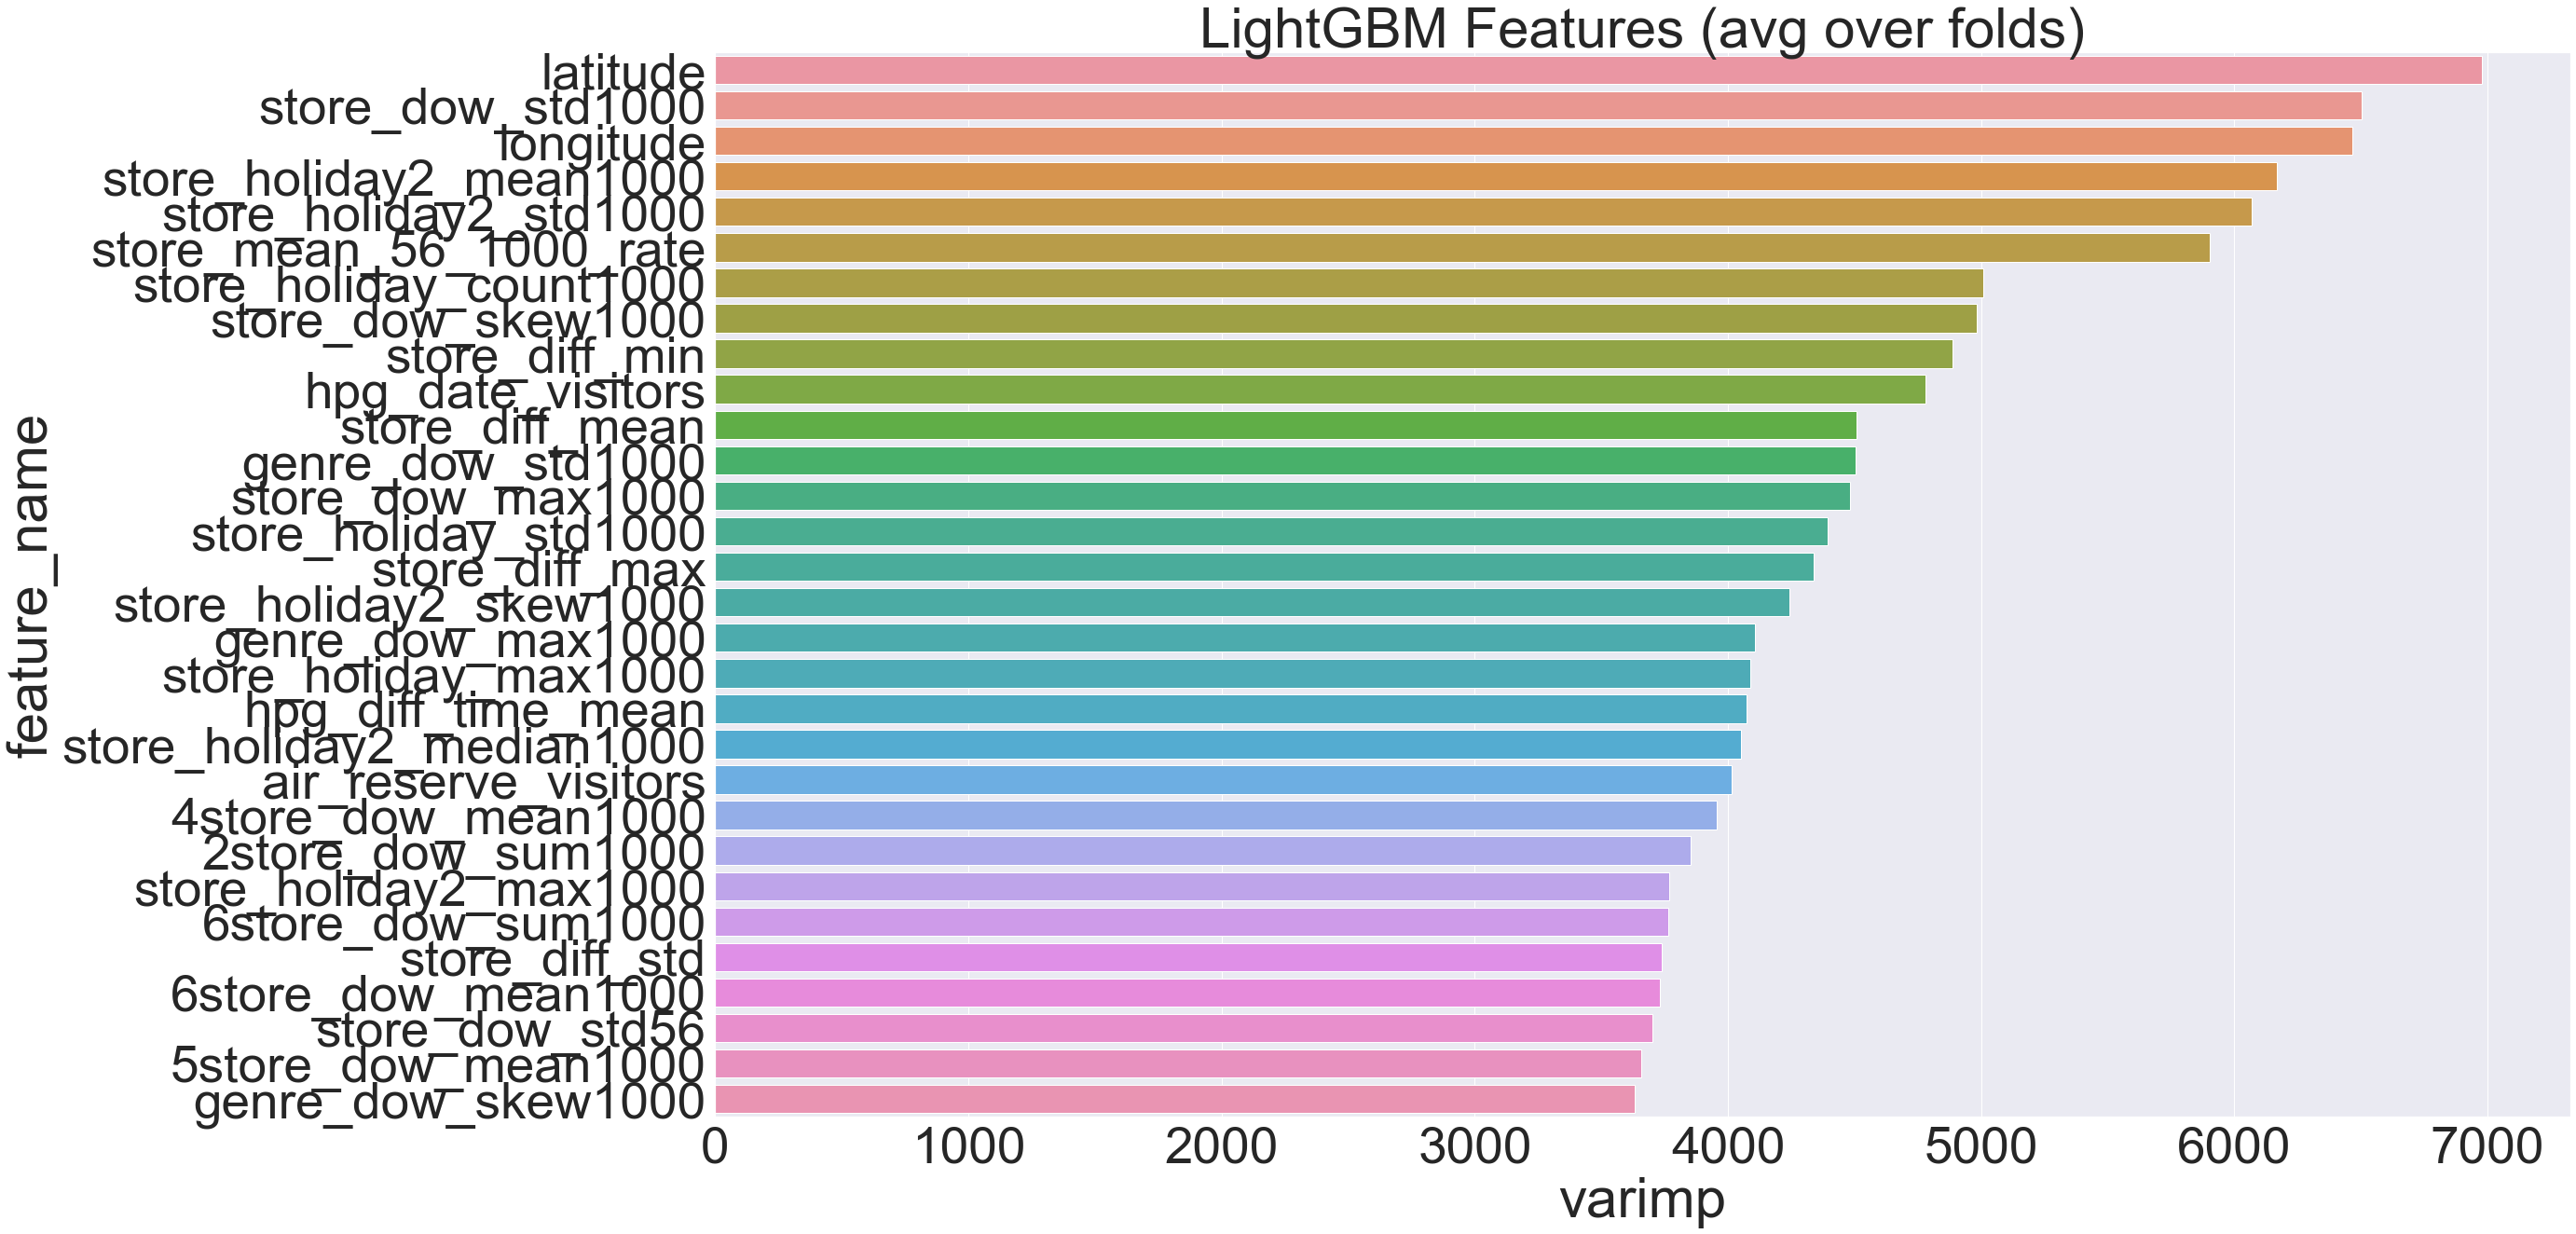

In [87]:
# feature_imp = feature_importances.groupby('feature').agg({'fold_1':'sum','fold_2':'sum','fold_3':'sum',
#                                             'fold_4':'sum','fold_5':'sum'}).sum(axis=1).sort_values(ascending=False)
# feature_imp = feature_imp.to_frame().reset_index().head(30)
# feature_imp.rename(columns={"feature": "feature_name", 0: "varimp"}, inplace=True)
# plt.figure(figsize=(40, 20))
# sns.set(font_scale = 5)
# sns.barplot(x="varimp", y="feature_name", data=feature_imp)
# plt.title('LightGBM Features (avg over folds)')
# plt.tight_layout()
# # plt.savefig('lgbm_importances-01.png')
# plt.show()

In [ ]:
# import datetime
# import lightgbm as lgb

# predictors = [f for f in test_feat.columns if f not in (['id','store_id','visit_date','end_date','air_area_name','visitors','month'])]

# params = {
#     'learning_rate': 0.02,
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'sub_feature': 0.7,
#     'num_leaves': 60,
#     'min_data': 100,
#     'min_hessian': 1,
#     'verbose': -1,
# }

# train = train_feat[train_feat['visit_date'] < '2017-03-12'].sort_values('visit_date')
# validation = train_feat[(train_feat['date'] >= '2017-03-12')].sort_values('visit_date')
# del train_feat


# t0 = time.time()
# lgb_train = lgb.Dataset(train_feat[predictors], train_feat['visitors'])
# lgb_test = lgb.Dataset(test_feat[predictors], test_feat['visitors'])

# lgbm = lgb.train(params,lgb_train, 2300)

#### Feature importance

In [33]:
def get_lgbm_varimp(model, train_columns, max_vars=50):
    """
    https://stackoverflow.com/questions/53413701/feature-importance-using-lightgbm
    """
    if "basic.Booster" in str(model.__class__):
        # lightgbm.basic.Booster was trained directly, so using feature_importance() function 
        cv_varimp_df = pd.DataFrame([train_columns, model.feature_importance()]).T
    else:
        # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
        # so using feature_importances_ property
        cv_varimp_df = pd.DataFrame([train_columns, model.feature_importances_]).T

    cv_varimp_df.columns = ['feature_name', 'varimp']

    cv_varimp_df.sort_values(by='varimp', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df

get_lgbm_varimp(lgbm, predictors).head(20)

,feature_name,varimp
372,hpg_diff_time_max,3251
2,latitude,2599
3,longitude,2570
217,store_holiday2_mean600,1791
221,store_holiday2_std600,1346
111,store_dow_std600,1279
134,store_diff_min,1223
213,store_holiday_count600,1185
393,store_mean_56_600_rate,1166
183,5store_dow_std600,1136


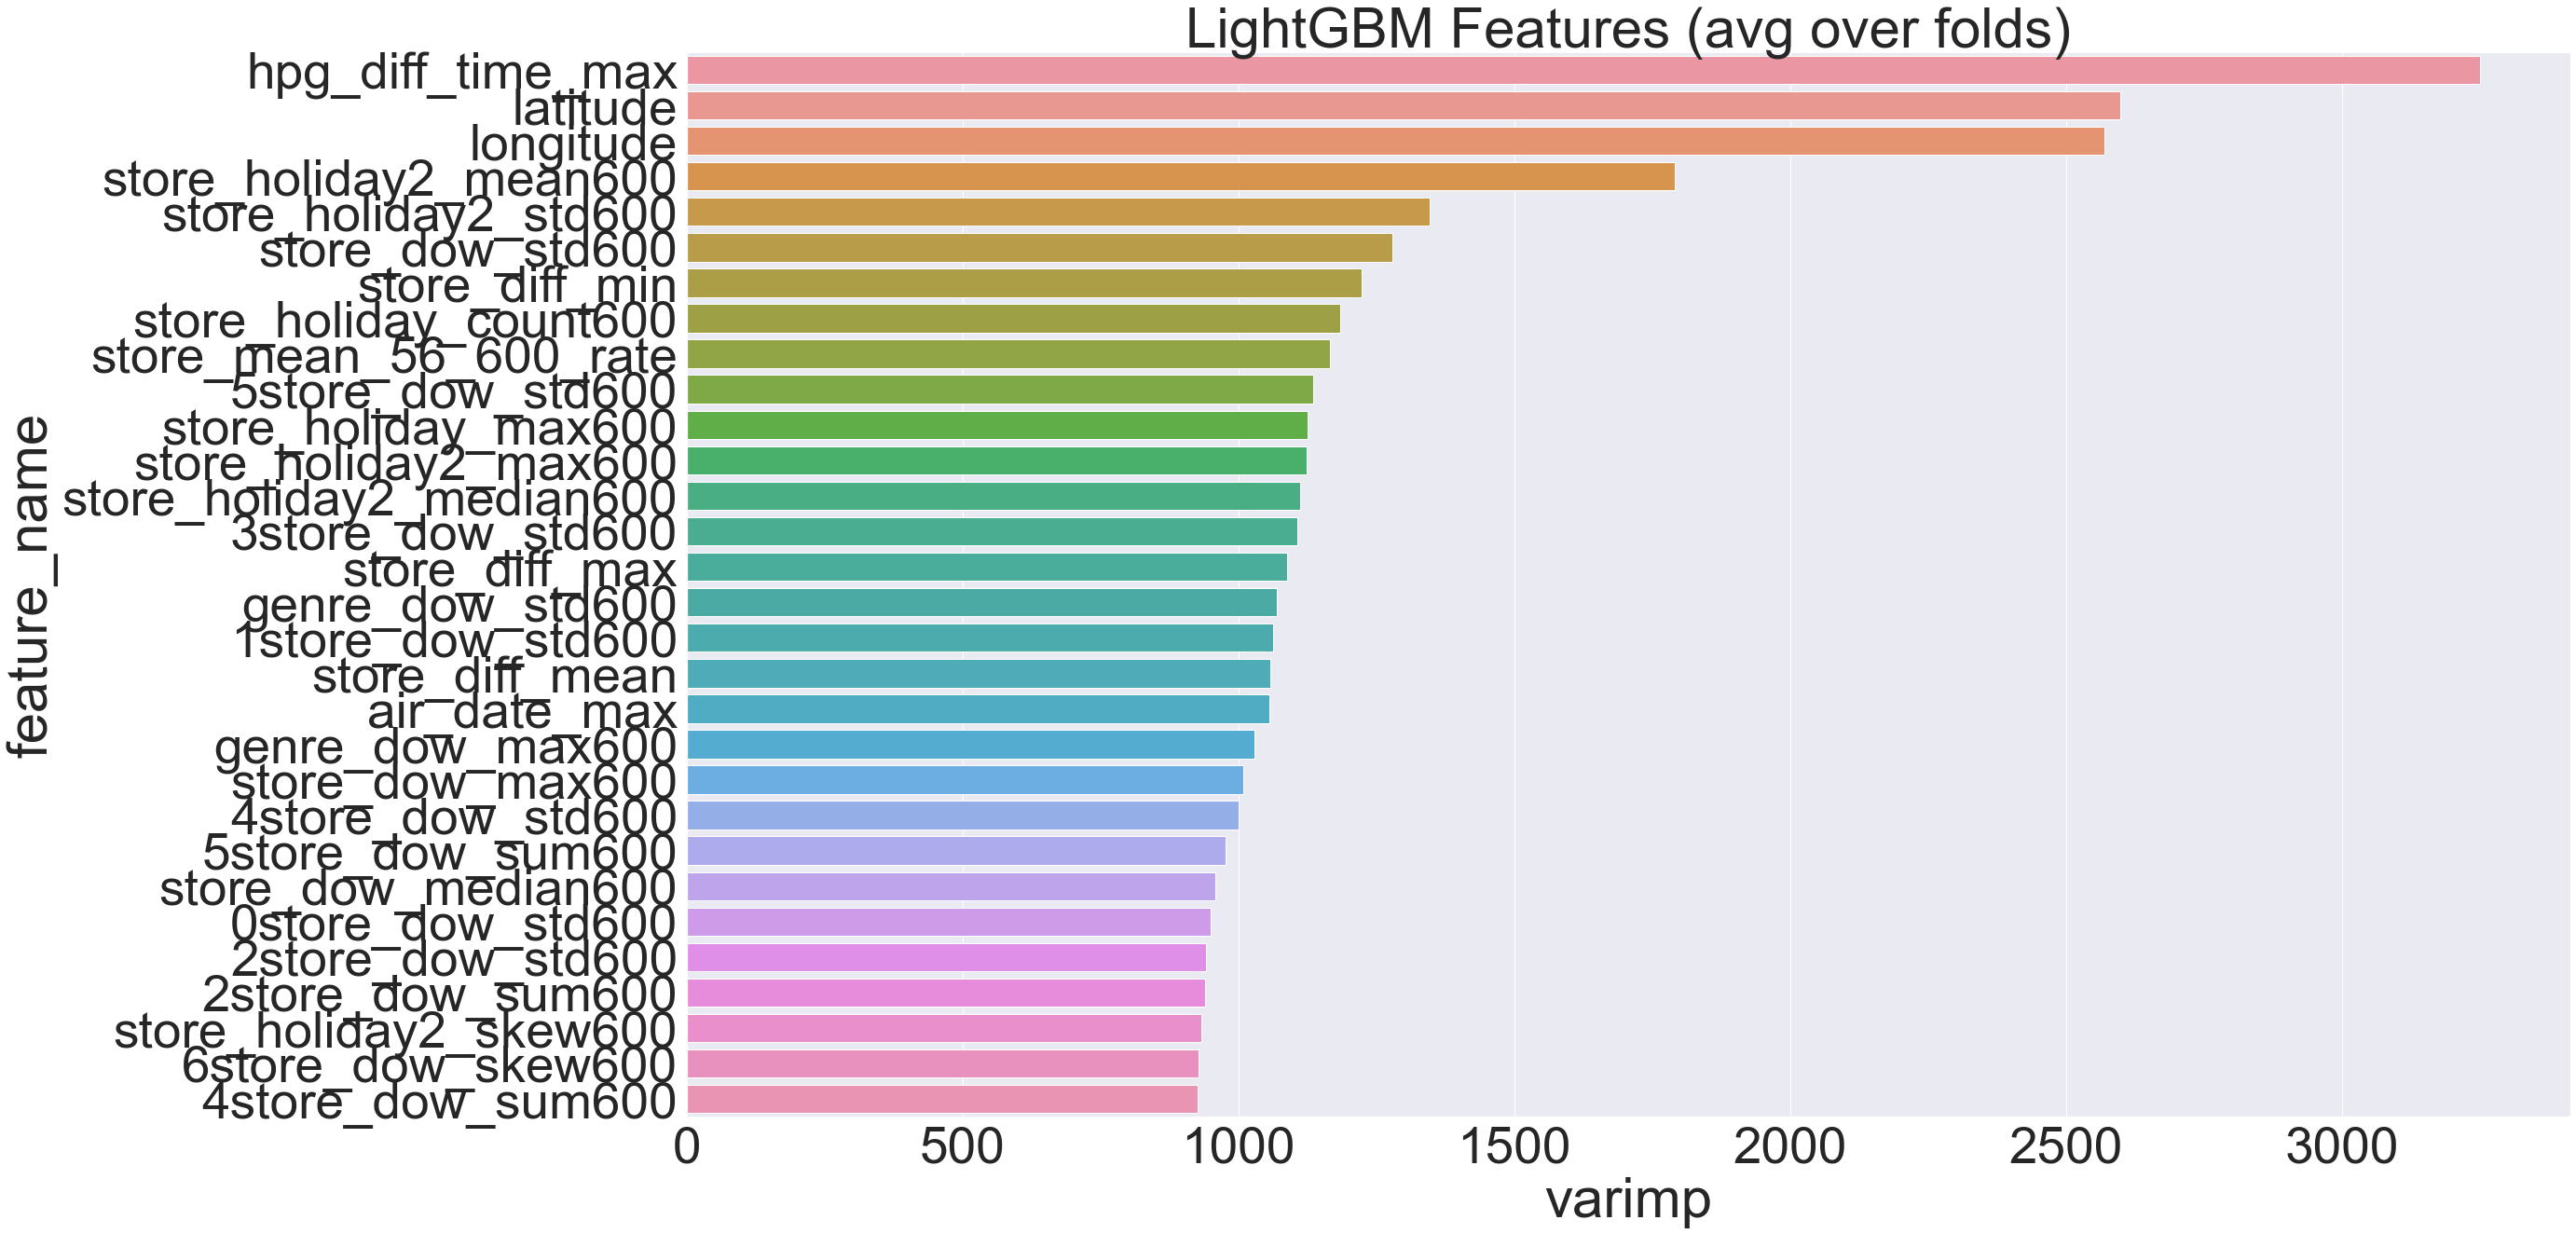

In [34]:
def plotImp(model, train_columns, max_vars=50):
    feature_imp = get_lgbm_varimp(model, train_columns, max_vars) 
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="varimp", y="feature_name", data=feature_imp)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances-01.png')
    plt.show()

plotImp(lgbm, predictors, 30)

In [35]:
print('Total Modeling {} seconds'.format(time.time() - t0))

Total Modeling 2104.9384939670563 seconds


### Prediction

In [36]:
pred = lgbm.predict(test_feat[predictors])

In [41]:
subm = pd.DataFrame({'id':test_feat.store_id + '_' + test_feat.visit_date,'visitors':np.expm1(pred)})
subm = submission[['id']].merge(subm,on='id',how='left').fillna(0)

In [42]:
# # holiday trick
# """
# https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/49272
# https://www.kaggle.com/h4211819/holiday-trick
# """

# start_date = '2017-05-03'
# date_comb_1 = '2017-04-29'
# date_comb_2 = '2017-05-13'

# for day in range(3):
#     ans = date_add_days(start_date, day)
#     print (ans)
#     subm.loc[test_feat.visit_date==ans,'visitors'] = np.sqrt(subm.loc[test_feat.visit_date==date_comb_1,'visitors'].values * \
#                                                              subm.loc[test_feat.visit_date==date_comb_2,'visitors'].values)

# subm.loc[test_feat.visit_date==date_add_days(start_date, -1),'visitors'] = \
#     np.sqrt(subm.loc[test_feat.visit_date==date_add_days(date_comb_1, -1),'visitors'].values * \
#             subm.loc[test_feat.visit_date==date_add_days(date_comb_2, -1),'visitors'].values)

2017-05-03
2017-05-04
2017-05-05


In [43]:
subm.to_csv(r'data/sub{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')),
                  index=False, float_format='%.4f')

In [44]:
subm

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,4.596192
1,air_00a91d42b08b08d9_2017-04-24,26.317902
2,air_00a91d42b08b08d9_2017-04-25,28.818452
3,air_00a91d42b08b08d9_2017-04-26,30.263533
4,air_00a91d42b08b08d9_2017-04-27,32.467116
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,6.176760
32015,air_fff68b929994bfbd_2017-05-28,3.525445
32016,air_fff68b929994bfbd_2017-05-29,2.999081
32017,air_fff68b929994bfbd_2017-05-30,3.765603
